In [1]:
#installations
!pip install --upgrade opencv-python mediapipe torch torchvision torchsummary seaborn gtts

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch [1/20]
Train Loss: 3.1029, Train Accuracy: 0.1187
Test Loss: 2.6073, Test Accuracy: 0.2975
--------------------------------------------------
Epoch [2/20]
Train Loss: 2.0171, Train Accuracy: 0.5479
Test Loss: 1.5955, Test Accuracy: 0.5785
--------------------------------------------------
Epoch [3/20]
Train Loss: 1.1548, Train Accuracy: 0.7479
Test Loss: 1.5816, Test Accuracy: 0.5950
--------------------------------------------------
Epoch [4/20]
Train Loss: 0.6677, Train Accuracy: 0.8708
Test Loss: 0.9972, Test Accuracy: 0.7438
--------------------------------------------------
Epoch [5/20]
Train Loss: 0.3971, Train Accuracy: 0.9104
Test Loss: 0.9243, Test Accuracy: 0.7521
--------------------------------------------------
Epoch [6/20]
Train Loss: 0.2634, Train Accuracy: 0.9521
Test Loss: 0.7474, Test Accuracy: 0.7934
--------------------------------------------------
Epoch [7/20]
Train Loss: 0.2139, Train Accuracy: 0.9542
Test Loss: 0.7162, Test Accuracy: 0.8595
---------------

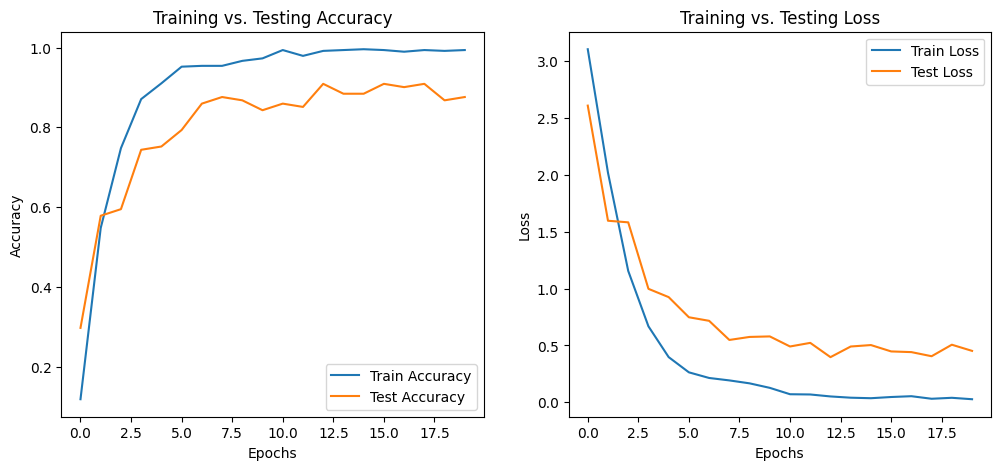

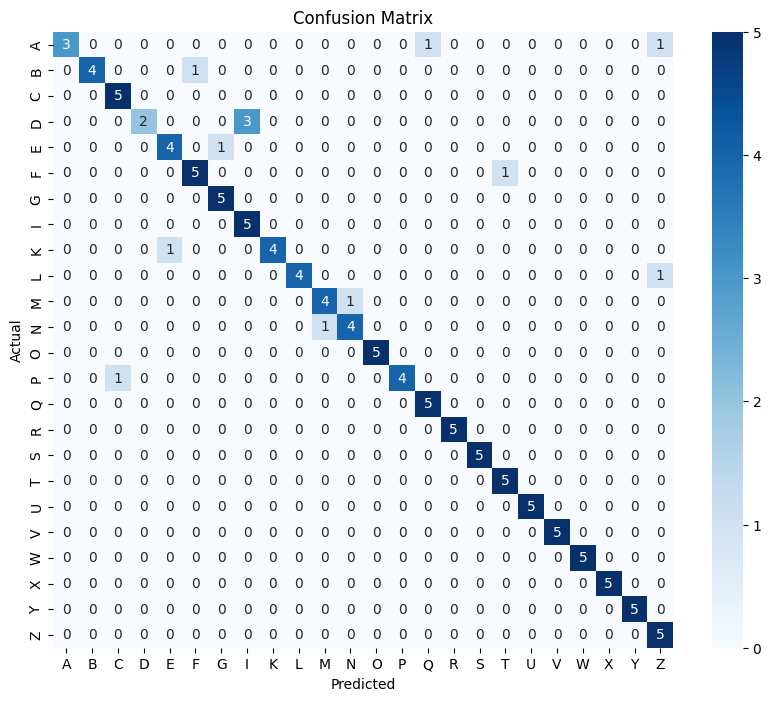

In [2]:
import os
import cv2
import numpy as np
import mediapipe as mp
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.models as models
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.metrics import confusion_matrix
from PIL import Image
from sklearn.model_selection import train_test_split

# ✅ Dataset path
dataset_path = "/kaggle/input/all-isl-datasets/ISL/ISL_Dataset_3"

# ✅ Class labels (A-Z)
char_to_label = {chr(65 + i): i for i in range(26)}
label_to_char = {v: k for k, v in char_to_label.items()}

# ✅ MediaPipe Hands
mp_hands = mp.solutions.hands
mp_drawing = mp.solutions.drawing_utils

# ✅ Function to extract hand keypoints
def extract_keypoints(image, max_hands=2):
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    keypoints = np.zeros(max_hands * 21 * 3)

    with mp_hands.Hands(static_image_mode=False, max_num_hands=max_hands, min_detection_confidence=0.7) as hands:
        results = hands.process(image_rgb)
        if results.multi_hand_landmarks:
            for h, hand_landmarks in enumerate(results.multi_hand_landmarks[:max_hands]):
                for i, landmark in enumerate(hand_landmarks.landmark):
                    keypoints[h * 21 * 3 + i * 3] = landmark.x
                    keypoints[h * 21 * 3 + i * 3 + 1] = landmark.y
                    keypoints[h * 21 * 3 + i * 3 + 2] = landmark.z
    return keypoints

# ✅ Custom Dataset Class
class ISLDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        label = self.labels[idx]
        image = cv2.imread(img_path)
        image = cv2.resize(image, (224, 224))
        keypoints = extract_keypoints(image, max_hands=2)

        if self.transform:
            image = Image.fromarray(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
            image = self.transform(image)

        return image, torch.tensor(keypoints, dtype=torch.float32), torch.tensor(label, dtype=torch.long)

# ✅ Load Image Paths and Labels
image_paths, labels = [], []
for class_name in sorted(os.listdir(dataset_path)):
    if class_name in char_to_label:
        class_dir = os.path.join(dataset_path, class_name)
        for img_name in os.listdir(class_dir):
            image_paths.append(os.path.join(class_dir, img_name))
            labels.append(char_to_label[class_name])

# ✅ Train-Test Split (80-20)
train_paths, test_paths, train_labels, test_labels = train_test_split(
    image_paths, labels, test_size=0.2, random_state=42, stratify=labels
)

# ✅ Data Transformations (Updated with extra augmentations)
transform = transforms.Compose([
    transforms.RandomRotation(20),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.2),
    transforms.GaussianBlur(3),
    transforms.RandomPerspective(distortion_scale=0.3, p=0.5),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# ✅ Create Datasets & Dataloaders
batch_size = 32
train_dataset = ISLDataset(train_paths, train_labels, transform=transform)
test_dataset = ISLDataset(test_paths, test_labels, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# ✅ Define Hybrid Model (ResNet34 + MLP with Dropout)
class ResNetMLP(nn.Module):
    def __init__(self, num_classes=26):
        super(ResNetMLP, self).__init__()
        self.resnet = models.resnet34(pretrained=True)
        self.resnet.fc = nn.Linear(512, 128)
        self.mlp = nn.Sequential(
            nn.Linear(2 * 21 * 3, 128),
            nn.ReLU(),
            nn.Dropout(0.3),  # Dropout for better generalization
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.3)
        )
        self.final_fc = nn.Linear(128 + 64, num_classes)

    def forward(self, image, keypoints):
        img_features = self.resnet(image)
        keypoint_features = self.mlp(keypoints)
        combined = torch.cat((img_features, keypoint_features), dim=1)
        return self.final_fc(combined)

# ✅ Training Setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ResNetMLP(num_classes=26).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0003, weight_decay=5e-4)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=15)

# ✅ Training Loop with Loss Calculation and Gradient Clipping
num_epochs = 20
train_loss_list, test_loss_list = [], []
train_acc_list, test_acc_list = [], []

for epoch in range(num_epochs):
    model.train()
    train_correct, train_total, running_train_loss = 0, 0, 0.0
    
    for images, keypoints, labels in train_loader:
        images, keypoints, labels = images.to(device), keypoints.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images, keypoints)
        loss = criterion(outputs, labels)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)  # Gradient Clipping
        optimizer.step()

        _, predicted = torch.max(outputs, 1)
        train_total += labels.size(0)
        train_correct += (predicted == labels).sum().item()
        running_train_loss += loss.item()

    train_loss_epoch = running_train_loss / len(train_loader)
    train_acc_epoch = train_correct / train_total
    train_loss_list.append(train_loss_epoch)
    train_acc_list.append(train_acc_epoch)

    # ✅ Testing Loop
    model.eval()
    test_correct, test_total, running_test_loss = 0, 0, 0.0

    with torch.no_grad():
        for images, keypoints, labels in test_loader:
            images, keypoints, labels = images.to(device), keypoints.to(device), labels.to(device)
            outputs = model(images, keypoints)
            loss = criterion(outputs, labels)
            running_test_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            test_total += labels.size(0)
            test_correct += (predicted == labels).sum().item()

    test_loss_epoch = running_test_loss / len(test_loader)
    test_acc_epoch = test_correct / test_total
    test_loss_list.append(test_loss_epoch)
    test_acc_list.append(test_acc_epoch)

    # ✅ Print Losses and Accuracies for Each Epoch
    print(f"Epoch [{epoch+1}/{num_epochs}]")
    print(f"Train Loss: {train_loss_epoch:.4f}, Train Accuracy: {train_acc_epoch:.4f}")
    print(f"Test Loss: {test_loss_epoch:.4f}, Test Accuracy: {test_acc_epoch:.4f}")
    print("-" * 50)

    scheduler.step()

# ✅ Save the trained model
torch.save(model.state_dict(), "ResNetMLP_ISL_3.pth")
print("Updated Model saved as 'ResNetMLP_ISL_3.pth'.")

# ✅ Plot Training Progress for Loss and Accuracy
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_acc_list, label="Train Accuracy")
plt.plot(test_acc_list, label="Test Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Training vs. Testing Accuracy")

plt.subplot(1, 2, 2)
plt.plot(train_loss_list, label="Train Loss")
plt.plot(test_loss_list, label="Test Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("Training vs. Testing Loss")
plt.show()

# ✅ Confusion Matrix
# Generate predictions on the test set to build a confusion matrix
all_preds, all_labels = [], []
model.eval()
with torch.no_grad():
    for images, keypoints, labels in test_loader:
        images, keypoints, labels = images.to(device), keypoints.to(device), labels.to(device)
        outputs = model(images, keypoints)
        _, predicted = torch.max(outputs, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

unique_labels = sorted(set(all_labels))
class_names = [label_to_char[i] for i in unique_labels]

cm = confusion_matrix(all_labels, all_preds, labels=unique_labels)
plt.figure(figsize=(10, 8))
sns.heatmap(pd.DataFrame(cm, index=class_names, columns=class_names), annot=True, cmap="Blues", fmt="d")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


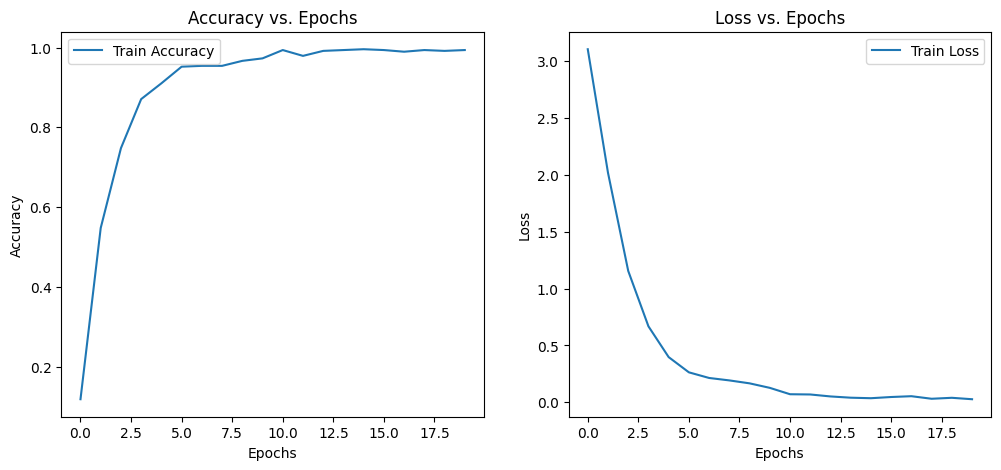

In [3]:
# ✅ Plot Training Progress
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_acc_list, label="Train Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Accuracy vs. Epochs")

plt.subplot(1, 2, 2)
plt.plot(train_loss_list, label="Train Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("Loss vs. Epochs")
plt.show()

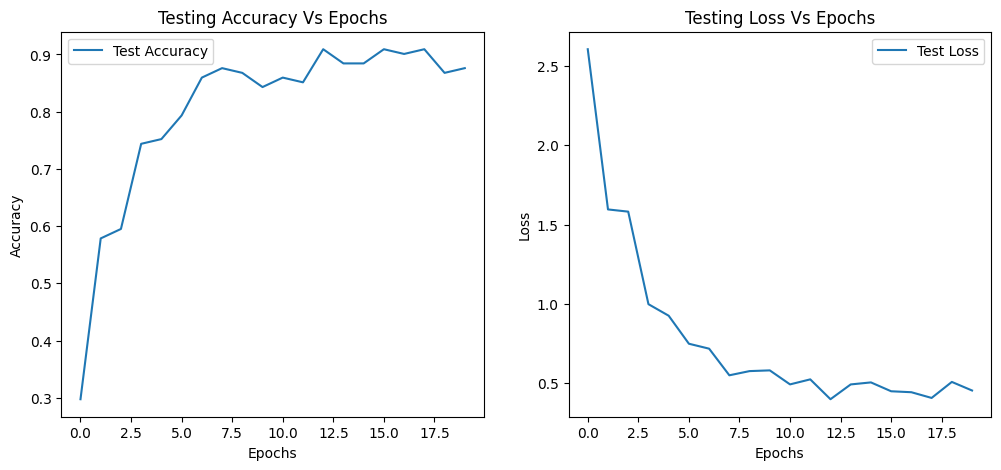

In [6]:
# ✅ Plot Training Progress for Loss and Accuracy
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(test_acc_list, label="Test Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Testing Accuracy Vs Epochs")

plt.subplot(1, 2, 2)
plt.plot(test_loss_list, label="Test Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("Testing Loss Vs Epochs")
plt.show()

In [4]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
# Convert lists to NumPy arrays
all_preds = np.array(all_preds)
all_labels = np.array(all_labels)

# ✅ Compute Evaluation Metrics
accuracy = accuracy_score(all_labels, all_preds)
precision = precision_score(all_labels, all_preds, average='macro')  # 'macro' gives equal weight to each class
recall = recall_score(all_labels, all_preds, average='macro')
f1 = f1_score(all_labels, all_preds, average='macro')

print(f"✅ Accuracy: {accuracy:.4f}")
print(f"✅ Precision: {precision:.4f}")
print(f"✅ Recall: {recall:.4f}")
print(f"✅ F1 Score: {f1:.4f}")

# ✅ Detailed Classification Report
print("\n✅ Classification Report:\n")
print(classification_report(all_labels, all_preds, target_names=class_names))


✅ Accuracy: 0.8926
✅ Precision: 0.9127
✅ Recall: 0.8931
✅ F1 Score: 0.8896

✅ Classification Report:

              precision    recall  f1-score   support

           A       1.00      0.60      0.75         5
           B       1.00      0.80      0.89         5
           C       0.83      1.00      0.91         5
           D       1.00      0.40      0.57         5
           E       0.80      0.80      0.80         5
           F       0.83      0.83      0.83         6
           G       0.83      1.00      0.91         5
           I       0.62      1.00      0.77         5
           K       1.00      0.80      0.89         5
           L       1.00      0.80      0.89         5
           M       0.80      0.80      0.80         5
           N       0.80      0.80      0.80         5
           O       1.00      1.00      1.00         5
           P       1.00      0.80      0.89         5
           Q       0.83      1.00      0.91         5
           R       1.00      1.00

In [5]:
import os
import cv2
import torch
import numpy as np
import mediapipe as mp
import torchvision.transforms as transforms
from PIL import Image
from gtts import gTTS
import IPython.display as ipd  # For playing audio in Kaggle Notebook

# ✅ Define Constants
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_path = "/kaggle/working/ResNetMLP_ISL_3.pth"  # Updated model path for new dataset

# ✅ Load Model
model = ResNetMLP(num_classes=26).to(device)  # Adjusted for A-Z classes
model.load_state_dict(torch.load(model_path, map_location=device))
model.eval()

# ✅ Character Mappings
label_to_char = {i: chr(65 + i) for i in range(26)}  # A-Z mapping

# ✅ Initialize MediaPipe
mp_hands = mp.solutions.hands

def extract_keypoints(image, max_hands=2):
    """Extracts keypoints from the image using MediaPipe Hands."""
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    keypoints = np.zeros(max_hands * 21 * 3)  # Pre-allocate keypoints array

    with mp_hands.Hands(static_image_mode=False, max_num_hands=max_hands, min_detection_confidence=0.7) as hands:
        results = hands.process(image_rgb)
        if results.multi_hand_landmarks:
            for h, hand_landmarks in enumerate(results.multi_hand_landmarks[:max_hands]):
                for i, landmark in enumerate(hand_landmarks.landmark):
                    keypoints[h * 21 * 3 + i * 3] = landmark.x
                    keypoints[h * 21 * 3 + i * 3 + 1] = landmark.y
                    keypoints[h * 21 * 3 + i * 3 + 2] = landmark.z
    return keypoints

# ✅ Define Image Transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# ✅ Get Image Paths from User Input /kaggle/input/all-isl-datasets/ISL/ISL_Dataset_3/A/A (1).jpg
dataset_path = "/kaggle/input/all-isl-datasets/ISL/ISL_Dataset_3/"
input_images = [
    os.path.join(dataset_path, "A", "A (1).jpg"),
    os.path.join(dataset_path, "B", "B (1).jpg"),
    os.path.join(dataset_path, "C", "C (1).jpg")
]

# ✅ Perform Prediction
predictions = []
for img_path in input_images:
    image = cv2.imread(img_path)
    if image is None:
        print(f"Error: Could not read image at {img_path}")
        continue

    image_rgb = Image.fromarray(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))  # Convert BGR to RGB
    image_tensor = transform(image_rgb).unsqueeze(0).to(device)  # Add batch dimension

    keypoints = extract_keypoints(image, max_hands=2)
    keypoints_tensor = torch.tensor(keypoints, dtype=torch.float32).unsqueeze(0).to(device)  # Add batch dimension

    with torch.no_grad():
        output = model(image_tensor, keypoints_tensor)
        predicted_label = torch.argmax(output, dim=1).item()
        predicted_char = label_to_char[predicted_label]
        predictions.append(predicted_char)

    print(f"Predicted Character for {os.path.basename(img_path)}: {predicted_char}")

# ✅ Convert Predicted Text to Speech
if predictions:
    predicted_text = "".join(predictions)
    print(f"\nFinal Predicted Text: {predicted_text}")

    tts = gTTS(predicted_text)
    tts.save("predicted_audio.mp3")
    ipd.display(ipd.Audio("predicted_audio.mp3"))  # Play in Kaggle Notebook
else:
    print("No predictions were made.")

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Predicted Character for A (1).jpg: A
Predicted Character for B (1).jpg: B
Predicted Character for C (1).jpg: C

Final Predicted Text: ABC
